In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.cluster import KMeans
from sklearn.ensemble import IsolationForest
import cv2
import os
from statsmodels.tsa.seasonal import STL
from zipfile import ZipFile

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Path to the zip file in Google Drive (change this to your file's path)
zip_path = '/content/drive/MyDrive/archive.zip'

In [4]:
# Extract the zip file
with ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall('/content/dataset')

In [40]:
# Reading the contents of the 'info.txt' and 'README_TRAFFICDB' files
info_txt_path = '/content/dataset/archive/info.txt'
readme_trafficdb_path = '/content/dataset/archive/README_TRAFFICDB'

with open(info_txt_path, 'r') as info_file:
    info_txt_content = info_file.read()

with open(readme_trafficdb_path, 'r') as readme_file:
    readme_trafficdb_content = readme_file.read()

info_txt_content, readme_trafficdb_content


('# filename, date(yyyymmdd), timestamp, direction, day/night, weather, start frame, number of frames, class, notes\ncctv052x2004080516x01638\t20040805\t16.01638\tsouth\tday\tovercast\t2\t53\tmedium\t\ncctv052x2004080516x01639\t20040805\t16.01639\tsouth\tday\tovercast\t2\t53\tmedium\t\ncctv052x2004080516x01640\t20040805\t16.01640\tsouth\tday\tovercast\t2\t48\tlight\t\ncctv052x2004080516x01641\t20040805\t16.01641\tsouth\tday\tovercast\t2\t52\tmedium\t\ncctv052x2004080516x01642\t20040805\t16.01642\tsouth\tday\tovercast\t2\t51\tmedium\t\ncctv052x2004080516x01643\t20040805\t16.01643\tsouth\tday\tovercast\t2\t53\tmedium\t\ncctv052x2004080516x01644\t20040805\t16.01644\tsouth\tday\tclear\t2\t53\tmedium\t\ncctv052x2004080516x01645\t20040805\t16.01645\tsouth\tday\tovercast\t2\t52\tmedium\t\ncctv052x2004080516x01646\t20040805\t16.01646\tsouth\tday\tovercast\t2\t49\theavy\t\ncctv052x2004080516x01647\t20040805\t16.01647\tsouth\tday\tovercast\t2\t52\tmedium\t\ncctv052x2004080516x01648\t20040805\t16

In [43]:
import pandas as pd

# Parsing the content of info.txt into a dataframe
lines = info_txt_content.strip().split("\n")
data = [line.split("\t") for line in lines]

# Adjusting the columns list to match the data structure
columns = ['Video_ID', 'Date', 'Timestamp', 'Direction', 'Time_of_day', 'Weather',
           'Unknown1', 'Unknown2', 'Traffic_condition', 'Additional_Info']

# Creating dataframe
df_info = pd.DataFrame(data, columns=columns)

df_info.head()


,Video_ID,Date,Timestamp,Direction,Time_of_day,Weather,Unknown1,Unknown2,Traffic_condition,Additional_Info
0,"# filename, date(yyyymmdd), timestamp, directi...",None,None,None,None,None,None,None,None,None
1,cctv052x2004080516x01638,20040805,16.01638,south,day,overcast,2,53,medium,
2,cctv052x2004080516x01639,20040805,16.01639,south,day,overcast,2,53,medium,
3,cctv052x2004080516x01640,20040805,16.01640,south,day,overcast,2,48,light,
4,cctv052x2004080516x01641,20040805,16.01641,south,day,overcast,2,52,medium,


In [44]:
# Removing the first row
df_info = df_info.iloc[1:]

# Resetting the index
df_info.reset_index(drop=True, inplace=True)

df_info.head()


,Video_ID,Date,Timestamp,Direction,Time_of_day,Weather,Unknown1,Unknown2,Traffic_condition,Additional_Info
0,cctv052x2004080516x01638,20040805,16.01638,south,day,overcast,2,53,medium,
1,cctv052x2004080516x01639,20040805,16.01639,south,day,overcast,2,53,medium,
2,cctv052x2004080516x01640,20040805,16.01640,south,day,overcast,2,48,light,
3,cctv052x2004080516x01641,20040805,16.01641,south,day,overcast,2,52,medium,
4,cctv052x2004080516x01642,20040805,16.01642,south,day,overcast,2,51,medium,


In [45]:
# Checking for missing values in the dataframe
missing_values = df_info.isnull().sum()
missing_values_percentage = (df_info.isnull().sum() / len(df_info)) * 100

pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_values_percentage
})


,Missing Values,Percentage
Video_ID,0,0.000000
Date,0,0.000000
Timestamp,0,0.000000
Direction,0,0.000000
Time_of_day,0,0.000000
Weather,0,0.000000
Unknown1,0,0.000000
Unknown2,0,0.000000
Traffic_condition,0,0.000000
Additional_Info,1,0.393701


In [46]:
# Filling the missing value in the 'Additional_Info' column with an empty string
df_info['Additional_Info'].fillna("", inplace=True)

# Checking again for missing values to confirm
missing_after_fill = df_info['Additional_Info'].isnull().sum()
missing_after_fill


0

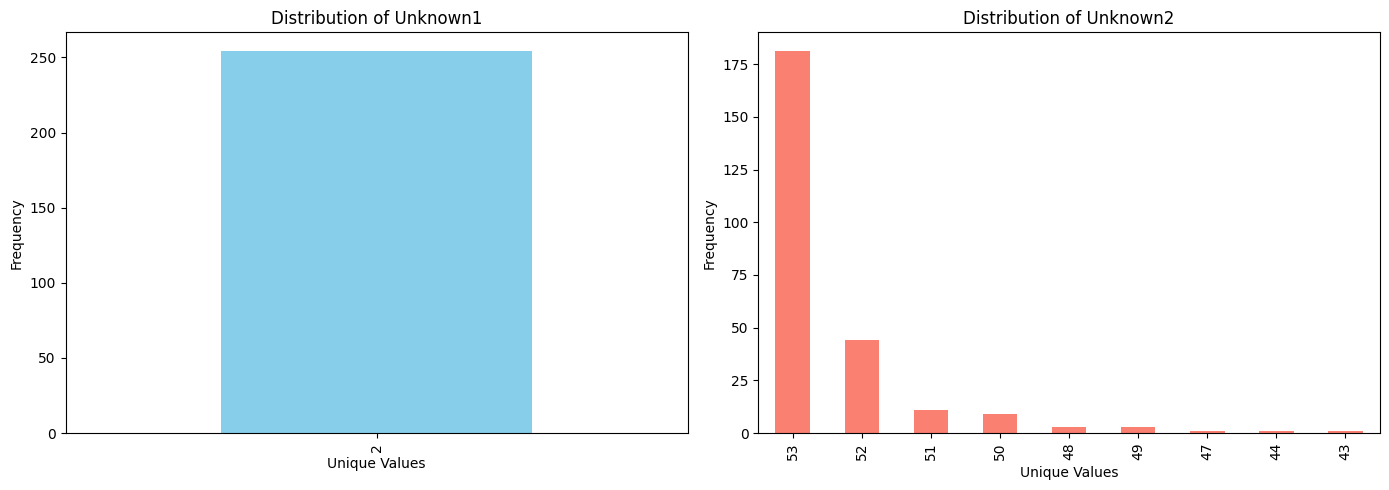

In [47]:
import matplotlib.pyplot as plt

# Plotting the distributions for the Unknown1 and Unknown2 columns
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 5))

# Unknown1 column distribution
df_info['Unknown1'].value_counts().plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Distribution of Unknown1')
axes[0].set_xlabel('Unique Values')
axes[0].set_ylabel('Frequency')

# Unknown2 column distribution
df_info['Unknown2'].value_counts().plot(kind='bar', ax=axes[1], color='salmon')
axes[1].set_title('Distribution of Unknown2')
axes[1].set_xlabel('Unique Values')
axes[1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


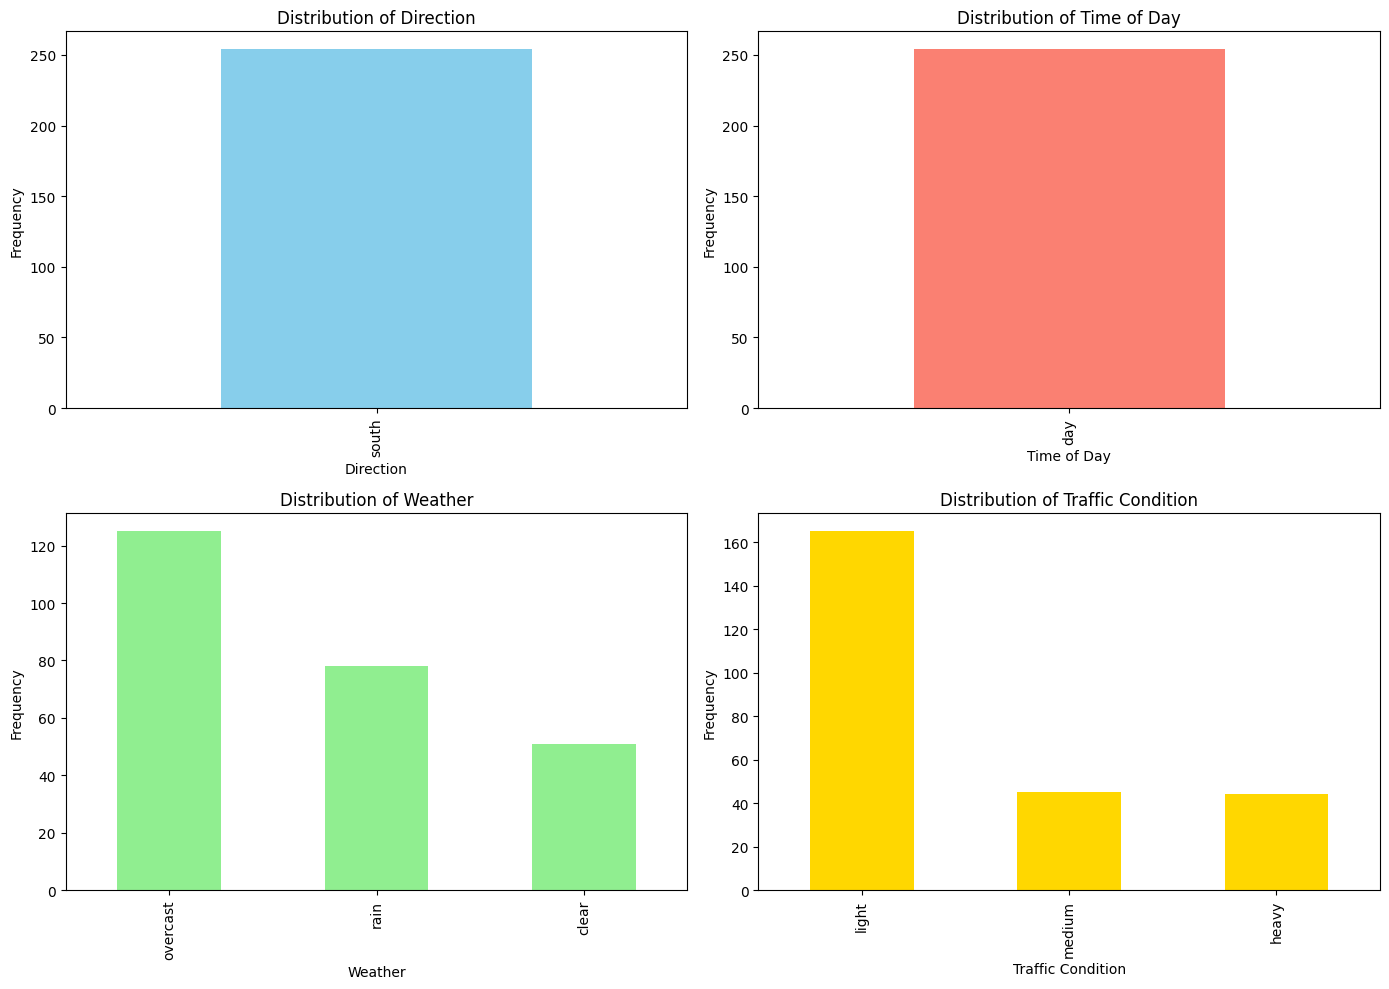

Direction            1
Time_of_day          1
Weather              3
Traffic_condition    3
dtype: int64

In [48]:
# Examining the distributions and unique values in the other columns

# Creating subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Direction column distribution
df_info['Direction'].value_counts().plot(kind='bar', ax=axes[0, 0], color='skyblue')
axes[0, 0].set_title('Distribution of Direction')
axes[0, 0].set_xlabel('Direction')
axes[0, 0].set_ylabel('Frequency')

# Time_of_day column distribution
df_info['Time_of_day'].value_counts().plot(kind='bar', ax=axes[0, 1], color='salmon')
axes[0, 1].set_title('Distribution of Time of Day')
axes[0, 1].set_xlabel('Time of Day')
axes[0, 1].set_ylabel('Frequency')

# Weather column distribution
df_info['Weather'].value_counts().plot(kind='bar', ax=axes[1, 0], color='lightgreen')
axes[1, 0].set_title('Distribution of Weather')
axes[1, 0].set_xlabel('Weather')
axes[1, 0].set_ylabel('Frequency')

# Traffic_condition column distribution
df_info['Traffic_condition'].value_counts().plot(kind='bar', ax=axes[1, 1], color='gold')
axes[1, 1].set_title('Distribution of Traffic Condition')
axes[1, 1].set_xlabel('Traffic Condition')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()

# Displaying unique values of non-numeric columns
unique_values = df_info[['Direction', 'Time_of_day', 'Weather', 'Traffic_condition']].nunique()
unique_values


In [49]:
# Converting 'Date' and 'Timestamp' columns to a combined datetime column
df_info['Datetime'] = pd.to_datetime(df_info['Date'] + df_info['Timestamp'], format='%Y%m%d%H.%f')

# Dropping the original 'Date' and 'Timestamp' columns as they are now redundant
df_info.drop(['Date', 'Timestamp'], axis=1, inplace=True)

# Ensuring categorical columns are of object data type
categorical_columns = ['Direction', 'Time_of_day', 'Weather', 'Traffic_condition']
df_info[categorical_columns] = df_info[categorical_columns].astype('object')

# Displaying data types of all columns
df_info.dtypes


Video_ID                     object
Direction                    object
Time_of_day                  object
Weather                      object
Unknown1                     object
Unknown2                     object
Traffic_condition            object
Additional_Info              object
Datetime             datetime64[ns]
dtype: object

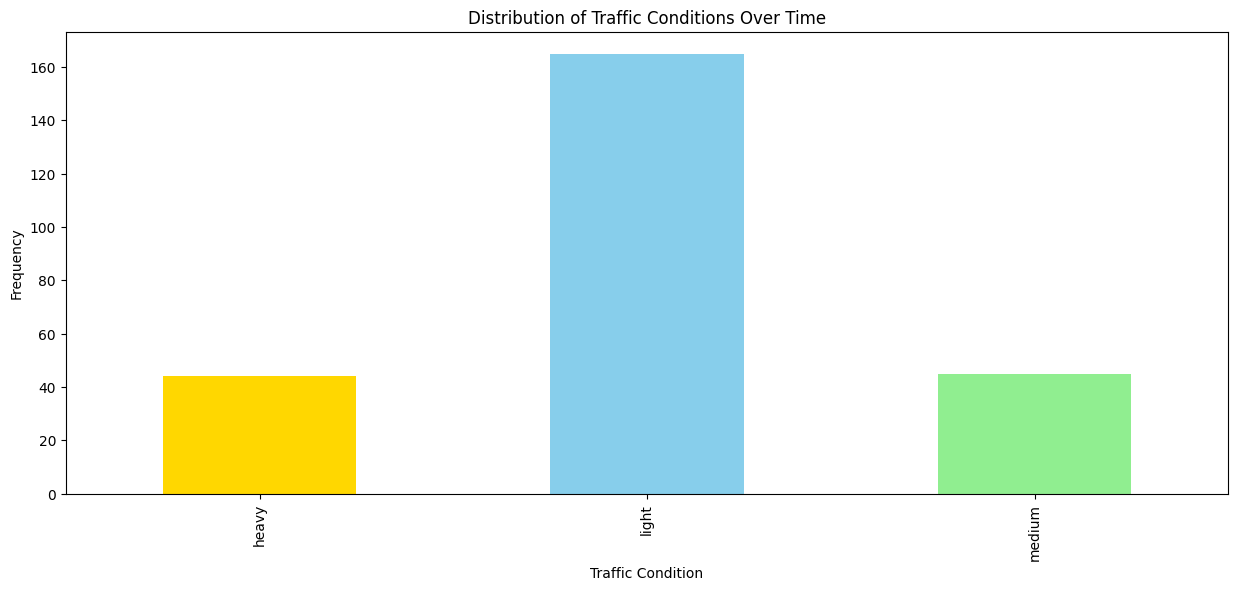

In [50]:
# Plotting the distribution of traffic conditions over time

# Grouping by Datetime and aggregating by the most frequent traffic condition for each time
traffic_over_time = df_info.groupby('Datetime')['Traffic_condition'].agg(lambda x: x.value_counts().index[0])

# Plotting
plt.figure(figsize=(15, 6))
traffic_over_time.value_counts().sort_index().plot(kind='bar', color=['gold', 'skyblue', 'lightgreen'])
plt.title('Distribution of Traffic Conditions Over Time')
plt.xlabel('Traffic Condition')
plt.ylabel('Frequency')
plt.show()


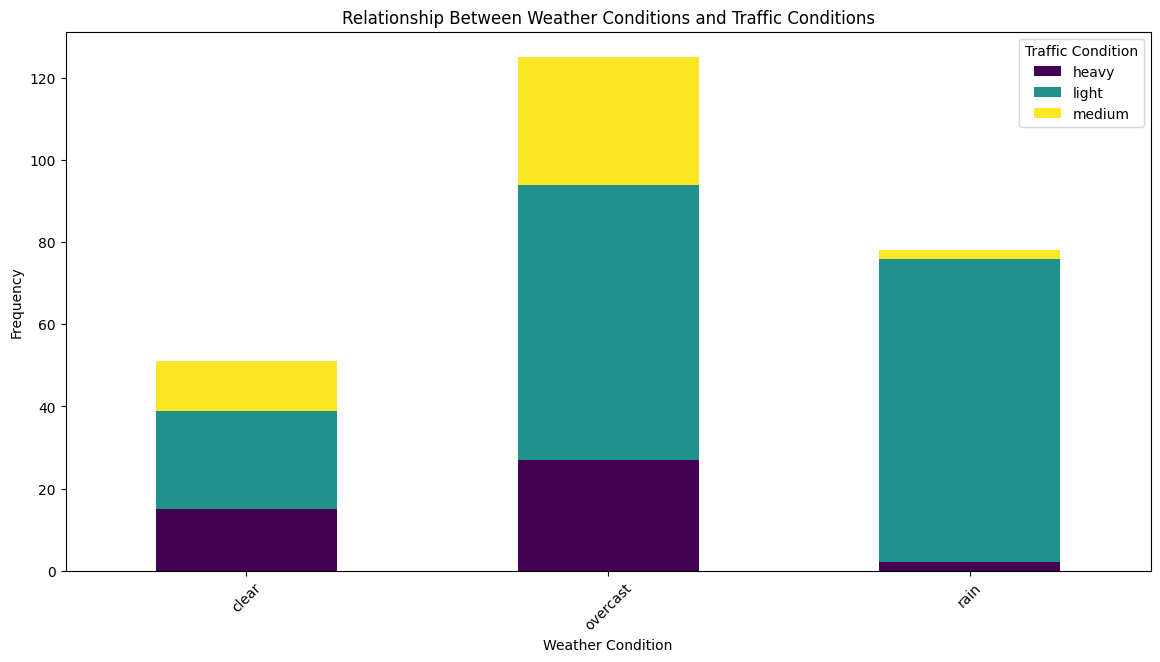

In [51]:
# Investigating the relationship between weather conditions and traffic conditions

# Grouping by Weather and Traffic_condition to get the counts
weather_traffic_df = df_info.groupby(['Weather', 'Traffic_condition']).size().unstack()

# Plotting
weather_traffic_df.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Relationship Between Weather Conditions and Traffic Conditions')
plt.xlabel('Weather Condition')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.legend(title='Traffic Condition')
plt.show()


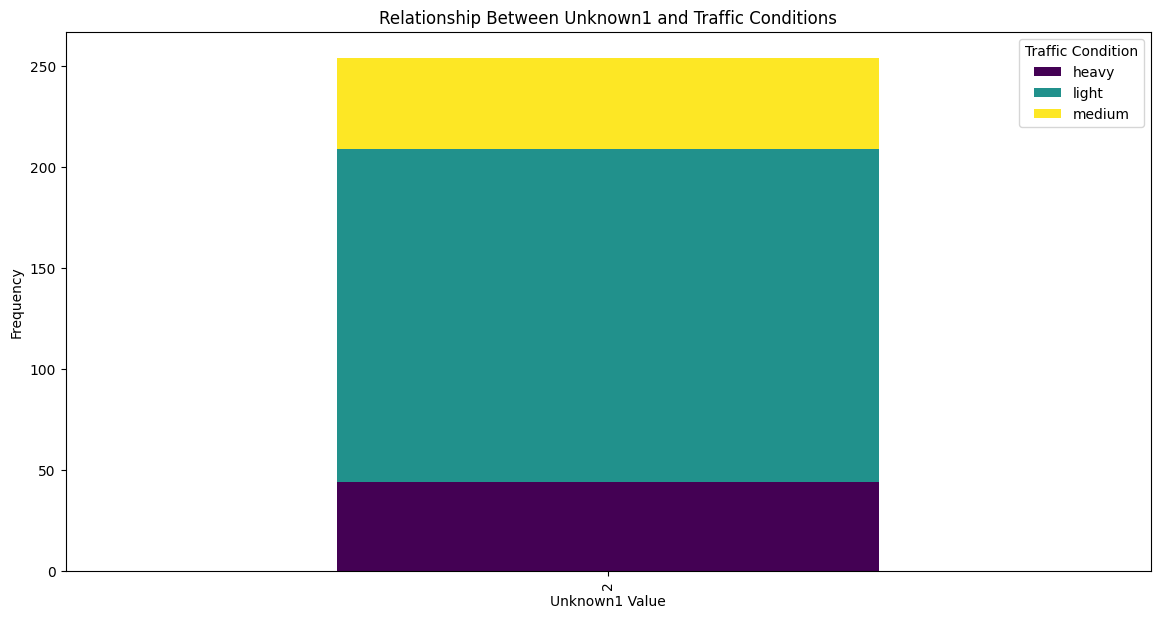

In [52]:
# Investigating the relationship between Unknown1 and traffic conditions

# Grouping by Unknown1 and Traffic_condition to get the counts
unknown1_traffic_df = df_info.groupby(['Unknown1', 'Traffic_condition']).size().unstack()

# Plotting
unknown1_traffic_df.plot(kind='bar', stacked=True, figsize=(14, 7), colormap='viridis')
plt.title('Relationship Between Unknown1 and Traffic Conditions')
plt.xlabel('Unknown1 Value')
plt.ylabel('Frequency')
plt.legend(title='Traffic Condition')
plt.show()


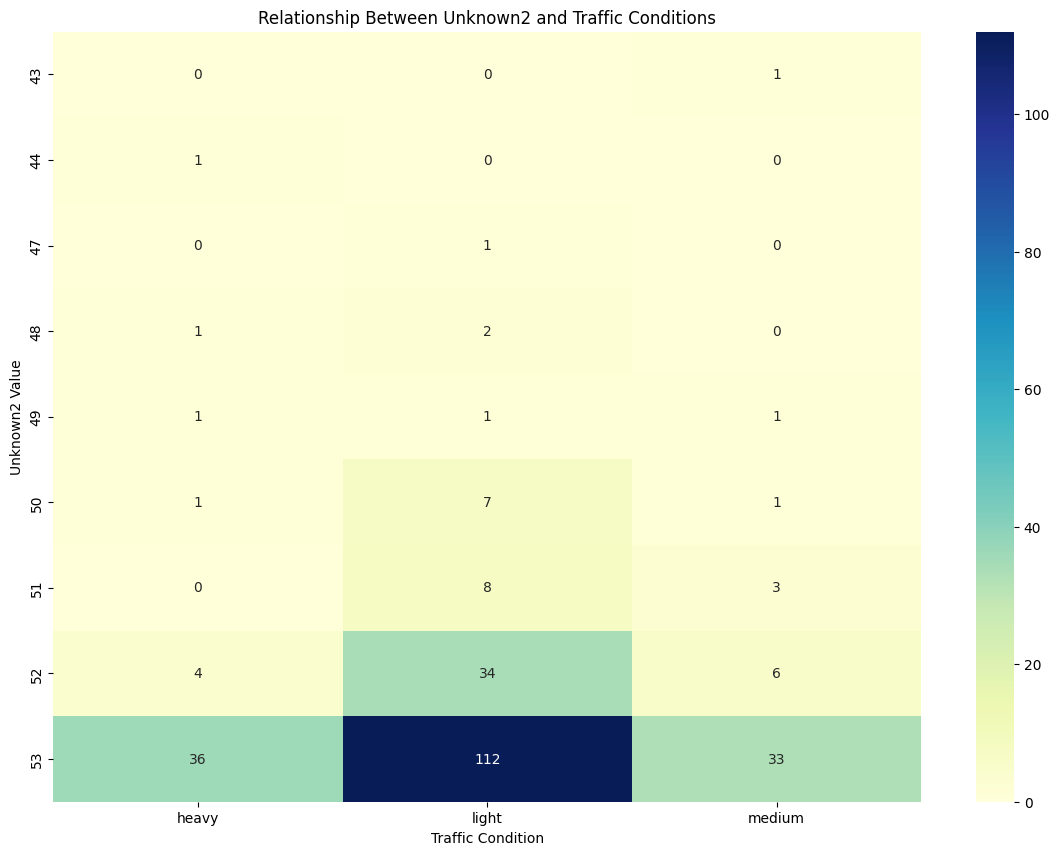

In [53]:
import seaborn as sns

# Investigating the relationship between Unknown2 and traffic conditions

# Grouping by Unknown2 and Traffic_condition to get the counts
unknown2_traffic_df = df_info.groupby(['Unknown2', 'Traffic_condition']).size().unstack().fillna(0)

# Plotting a heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(unknown2_traffic_df, cmap="YlGnBu", annot=True, fmt=".0f")
plt.title('Relationship Between Unknown2 and Traffic Conditions')
plt.ylabel('Unknown2 Value')
plt.xlabel('Traffic Condition')
plt.show()


In [54]:
from sklearn.preprocessing import LabelEncoder

# Encoding categorical columns into numerical values for clustering
label_encoders = {}
columns_to_encode = ['Weather', 'Unknown1', 'Unknown2', 'Traffic_condition']

for col in columns_to_encode:
    le = LabelEncoder()
    df_info[col + '_encoded'] = le.fit_transform(df_info[col])
    label_encoders[col] = le

# Extracting the encoded columns for clustering
df_cluster = df_info[['Weather_encoded', 'Unknown1_encoded', 'Unknown2_encoded', 'Traffic_condition_encoded']]

df_cluster.head()


,Weather_encoded,Unknown1_encoded,Unknown2_encoded,Traffic_condition_encoded
0,1,0,8,2
1,1,0,8,2
2,1,0,3,1
3,1,0,7,2
4,1,0,6,2


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:8

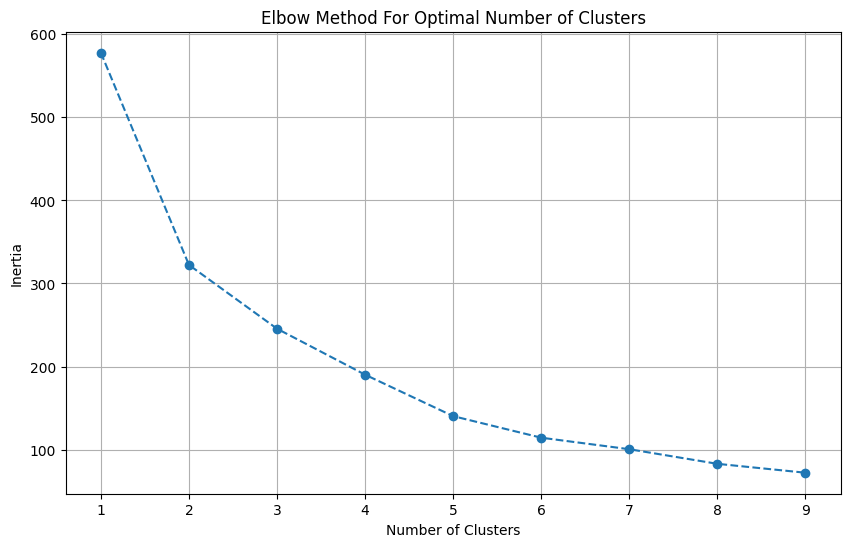

In [55]:
from sklearn.cluster import KMeans

# Elbow method to determine the optimal number of clusters
inertia = []
cluster_range = range(1, 10)

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster)
    inertia.append(kmeans.inertia_)

# Plotting the elbow curve
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, inertia, marker='o', linestyle='--')
plt.title('Elbow Method For Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()


In [56]:
# Applying KMeans clustering with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
df_info['Cluster'] = kmeans.fit_predict(df_cluster)

# Examining the characteristics of each cluster
cluster_characteristics = df_info.groupby('Cluster').agg({
    'Weather': lambda x: x.value_counts().index[0],
    'Unknown1': 'mean',
    'Unknown2': 'mean',
    'Traffic_condition': lambda x: x.value_counts().index[0],
    'Video_ID': 'count'
}).reset_index()

cluster_characteristics.columns = ['Cluster', 'Most Common Weather', 'Average Unknown1', 'Average Unknown2', 'Most Common Traffic Condition', 'Number of Entries']

cluster_characteristics


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


,Cluster,Most Common Weather,Average Unknown1,Average Unknown2,Most Common Traffic Condition,Number of Entries
0,0,overcast,1.696353e+128,4.086668e+259,light,131
1,1,rain,2.364066e+91,5.695240e+185,light,94
2,2,overcast,7.662835e+26,1.672929e+56,light,29


In [57]:
from sklearn.ensemble import IsolationForest

# Converting the Unknown1 column to numeric type for anomaly detection
df_info['Unknown1'] = pd.to_numeric(df_info['Unknown1'], errors='coerce')

# Applying Isolation Forest for anomaly detection on Unknown1 column
iso_forest = IsolationForest(contamination=0.05, random_state=42)
df_info['Anomaly_Unknown1'] = iso_forest.fit_predict(df_info[['Unknown1']])

# Extracting the anomalies for Unknown1
anomalies_unknown1 = df_info[df_info['Anomaly_Unknown1'] == -1][['Unknown1', 'Traffic_condition', 'Weather', 'Datetime']]

anomalies_unknown1.head()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Unknown1,Traffic_condition,Weather,Datetime


In [58]:
# Converting the Unknown2 column to numeric type for anomaly detection
df_info['Unknown2'] = pd.to_numeric(df_info['Unknown2'], errors='coerce')

# Applying Isolation Forest for anomaly detection on Unknown2 column
iso_forest_unknown2 = IsolationForest(contamination=0.05, random_state=42)
df_info['Anomaly_Unknown2'] = iso_forest_unknown2.fit_predict(df_info[['Unknown2']])

# Extracting the anomalies for Unknown2
anomalies_unknown2 = df_info[df_info['Anomaly_Unknown2'] == -1][['Unknown2', 'Traffic_condition', 'Weather', 'Datetime']]

anomalies_unknown2.head()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


,Unknown2,Traffic_condition,Weather,Datetime
2,48,light,overcast,2004-08-05 16:00:00.016400
8,49,heavy,overcast,2004-08-05 16:00:00.016460
47,49,light,overcast,2004-08-05 19:00:00.016860
62,47,light,rain,2004-08-06 06:00:00.018210
155,48,light,rain,2004-08-06 12:00:00.019110


In [59]:
# Sampling videos based on specific criteria

# Light traffic and clear weather
sample1 = df_info[(df_info['Traffic_condition'] == 'light') & (df_info['Weather'] == 'clear')].sample(1)

# Medium traffic and overcast weather
sample2 = df_info[(df_info['Traffic_condition'] == 'medium') & (df_info['Weather'] == 'overcast')].sample(1)

# Heavy traffic and rainy weather
sample3 = df_info[(df_info['Traffic_condition'] == 'heavy') & (df_info['Weather'] == 'rain')].sample(1)

# Combining the samples
sampled_videos = pd.concat([sample1, sample2, sample3])

sampled_videos[['Video_ID', 'Traffic_condition', 'Weather']]


,Video_ID,Traffic_condition,Weather
169,cctv052x2004080613x00017,light,clear
1,cctv052x2004080516x01639,medium,overcast
184,cctv052x2004080615x00032,heavy,rain


In [60]:
import cv2
import os

# Define a function to extract frames from a video
def extract_frames(video_path, output_dir, num_frames=5):
    """
    Extract frames from a video.

    Parameters:
    - video_path: Path to the video file.
    - output_dir: Directory to save the extracted frames.
    - num_frames: Number of frames to extract from the video.

    Returns:
    - List of paths to the extracted frames.
    """
    # Ensure the output directory exists
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Open the video using OpenCV
    cap = cv2.VideoCapture(video_path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    frame_step = total_frames // num_frames

    frame_paths = []
    for i in range(num_frames):
        frame_num = i * frame_step
        cap.set(cv2.CAP_PROP_POS_FRAMES, frame_num)
        ret, frame = cap.read()
        if ret:
            frame_path = os.path.join(output_dir, f"frame_{frame_num}.jpg")
            cv2.imwrite(frame_path, frame)
            frame_paths.append(frame_path)

    # Release the video capture object
    cap.release()

    return frame_paths

# Paths to the video files
video_paths = [os.path.join("/mnt/data/videos", video_id + ".mpg") for video_id in sampled_videos['Video_ID']]

# Extract frames from each video
extracted_frames = []
for video_path in video_paths:
    video_name = os.path.basename(video_path).split('.')[0]
    frames = extract_frames(video_path, os.path.join("/mnt/data/frames", video_name))
    extracted_frames.extend(frames)

extracted_frames


[]

In [61]:
# Check if the selected video files are present in the provided dataset
video_files_exist = [os.path.exists(video_path) for video_path in video_paths]
video_files_exist


[False, False, False]

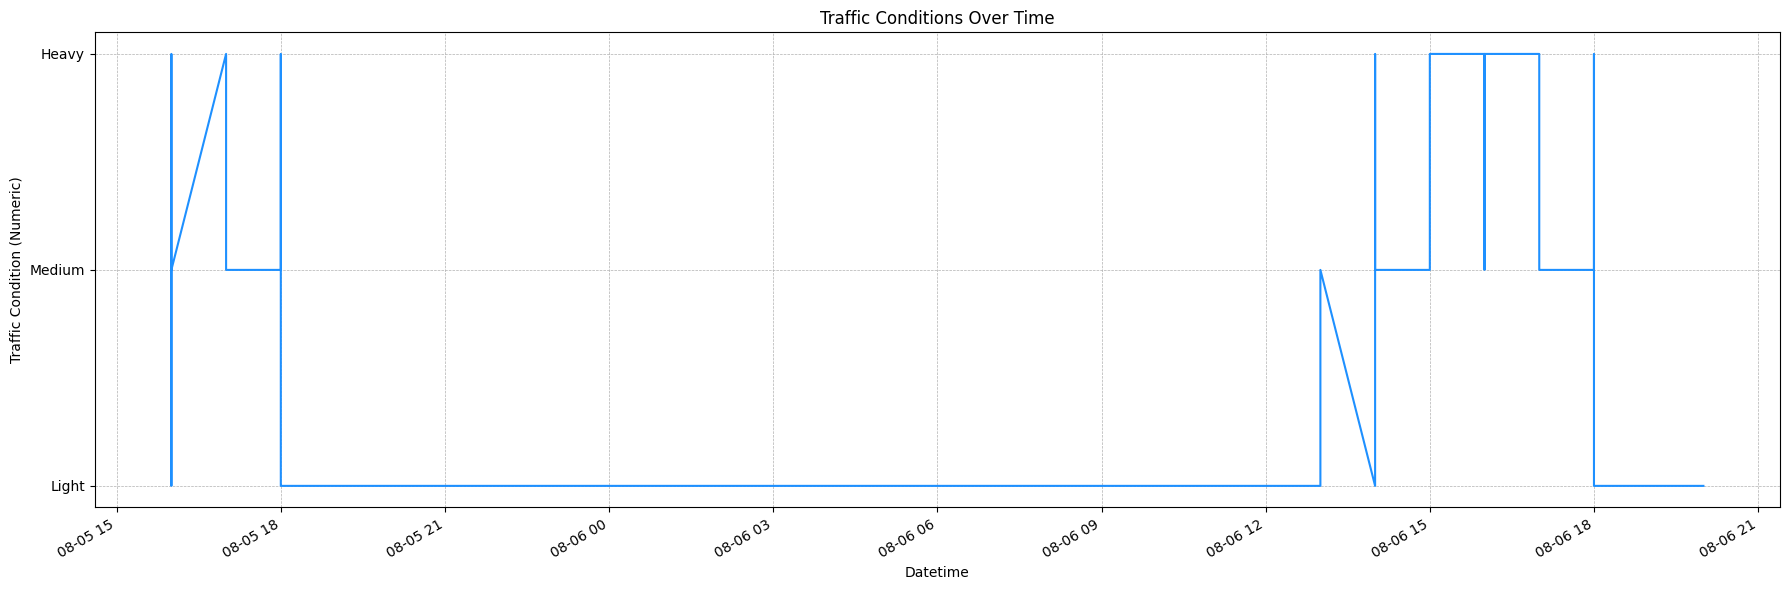

In [62]:
# Creating a numerical representation for traffic conditions for visualization
traffic_condition_mapping = {'light': 1, 'medium': 2, 'heavy': 3}
df_info['Traffic_condition_numeric'] = df_info['Traffic_condition'].map(traffic_condition_mapping)

# Plotting traffic conditions over time
plt.figure(figsize=(18, 6))
df_info.set_index('Datetime')['Traffic_condition_numeric'].plot(linewidth=1.5, color='dodgerblue')
plt.title('Traffic Conditions Over Time')
plt.xlabel('Datetime')
plt.ylabel('Traffic Condition (Numeric)')
plt.yticks([1, 2, 3], ['Light', 'Medium', 'Heavy'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


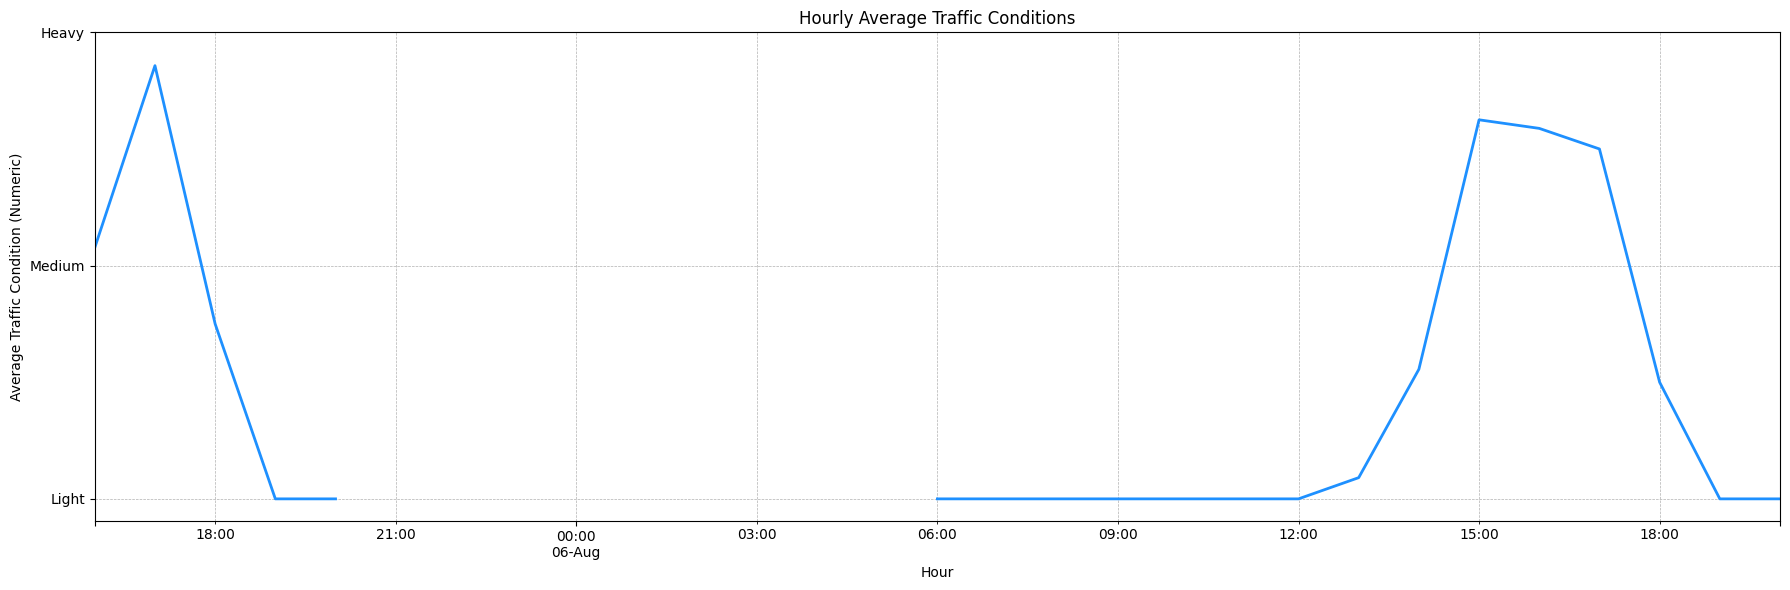

In [63]:
# Resampling the data to hourly frequency and computing the mean traffic condition for each hour
hourly_traffic = df_info.resample('H', on='Datetime')['Traffic_condition_numeric'].mean()

# Plotting the hourly average traffic conditions
plt.figure(figsize=(18, 6))
hourly_traffic.plot(linewidth=2, color='dodgerblue')
plt.title('Hourly Average Traffic Conditions')
plt.xlabel('Hour')
plt.ylabel('Average Traffic Condition (Numeric)')
plt.yticks([1, 2, 3], ['Light', 'Medium', 'Heavy'])
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


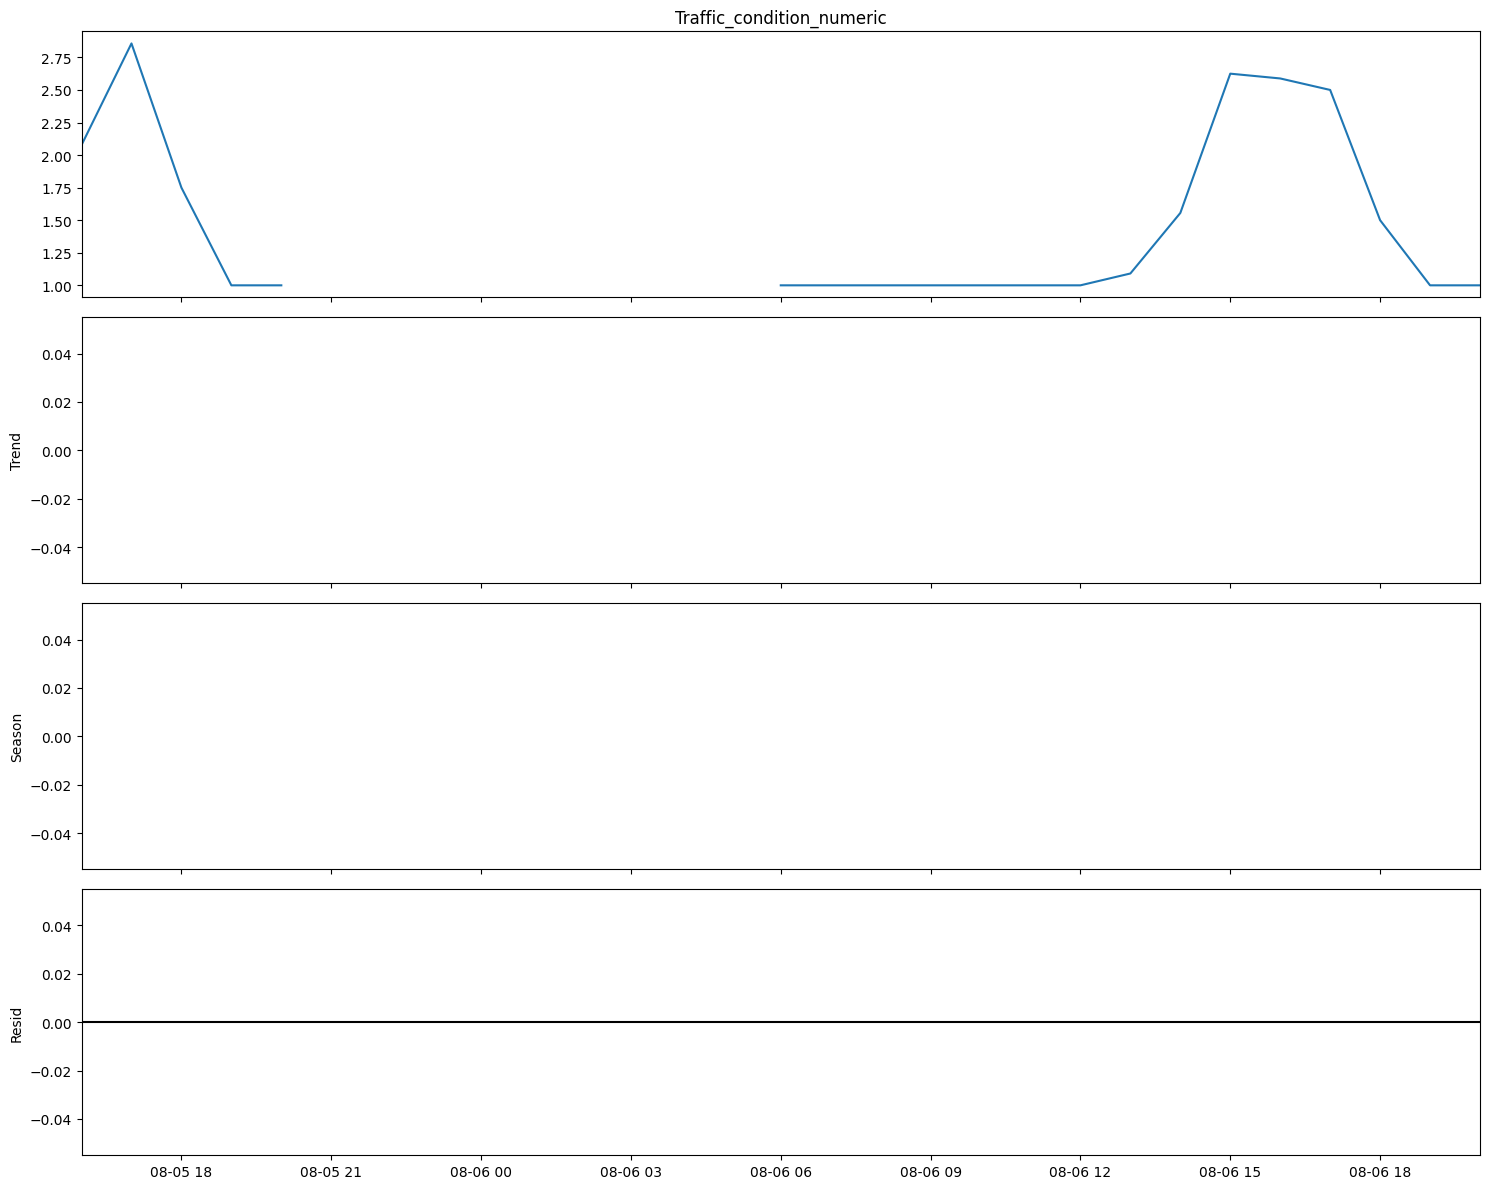

In [64]:
from statsmodels.tsa.seasonal import STL

# Decomposing the time series
stl = STL(hourly_traffic, seasonal=13)  # Using a seasonal period of 13 hours based on observed patterns
result = stl.fit()

# Plotting the decomposed components
fig = result.plot()
fig.set_size_inches(15, 12)
plt.tight_layout()
plt.show()
